In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# model_path = "mtgv/MobileVLM_V2-1.7B"
model_path = "mtgv/MobileVLM_V2-3B"
# model_path = "mtgv/MobileVLM_V2-7B"

In [3]:
# !git clone https://github.com/Meituan-AutoML/MobileVLM.git
%cd -q MobileVLM

In [4]:
import torch
from PIL import Image

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria

from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN

In [5]:
disable_torch_init()
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path=model_path, load_8bit=True, load_4bit=True, device_map='auto', device='cuda')

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [6]:
pil_image = Image.open('../Screenshot from 2024-11-20 00-03-10.png').convert("RGB")
# pil_image = pil_image.crop((0, pil_image.height // 2 - 200, pil_image.width, pil_image.height // 2 + 200))
pil_image = pil_image.resize((pil_image.width // 4, pil_image.height // 4))

images = [pil_image]
images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)

In [7]:
# prompt = f"""
# 与えられた画像に基づいて、コースを逸脱しないようにカートを運転するためのアクションを選択してください。
# 選択肢は以下です。
  
#  - “↑”: 加速
#  - “↓”: 減速
#  - “←”: 左へ操舵
#  - “→”: 右へ操舵
# """

prompt = f"""
Based on the given image, choose an action to drive the cart so that it does not deviate from the course.
The choices are as follows
  
 - “↑”: Accelerate
 - “↓”: Decelerate
 - "←": Steer left
 - "→": Steer right
"""

temperature = None  # 0.5など設定する際は、do_sampleをTrueに
do_sample = False
top_p = None
num_beams = 1
max_new_tokens = 20

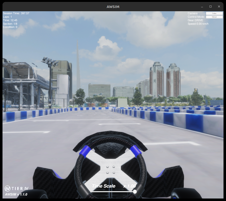


MobileVLM_V2の回答：
"↓"

CPU times: user 4.63 s, sys: 85 ms, total: 4.72 s
Wall time: 5.28 s


In [8]:
%%time

display(pil_image)

# プロンプト準備
conv = conv_templates["v1"].copy()
conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + prompt)
conv.append_message(conv.roles[1], None)
input_prompt = conv.get_prompt()

# ID変換
input_ids = (tokenizer_image_token(input_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda())
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

# 推論
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

# 処理結果デコード
input_token_len = input_ids.shape[1]
n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
if n_diff_input_output > 0:
    print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")
outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[: -len(stop_str)]

output_text = outputs.strip()

# 表示
print()
print("MobileVLM_V2の回答：")
print(output_text)
print()